In [1]:
pip install pandas nltk spacy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import libraries 
import pandas as pd
import numpy as np
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv('amazon_reviews.csv')  # Change the file path accordingly

# Check first few rows of data
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [8]:
# 1. Remove Missing Values
df = df.dropna()  # You can also use df.fillna() to replace missing values if needed
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4913 entries, 1 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4913 non-null   int64  
 1   reviewerName          4913 non-null   object 
 2   overall               4913 non-null   float64
 3   reviewText            4913 non-null   object 
 4   reviewTime            4913 non-null   object 
 5   day_diff              4913 non-null   int64  
 6   helpful_yes           4913 non-null   int64  
 7   helpful_no            4913 non-null   int64  
 8   total_vote            4913 non-null   int64  
 9   score_pos_neg_diff    4913 non-null   int64  
 10  score_average_rating  4913 non-null   float64
 11  wilson_lower_bound    4913 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 499.0+ KB


In [10]:

# 1. Drop 'Unnamed: 0' as it seems to be an index column and not necessary
df = df.drop(columns=['Unnamed: 0'])

# 2. Convert 'reviewTime' to a datetime object to standardize date format
df['reviewTime'] = pd.to_datetime(df['reviewTime'], errors='coerce')

# 3. Handle missing values:
# We'll fill missing numerical values with the column's mean or median if applicable.
df['reviewText'] = df['reviewText'].fillna('No review')  # Fill missing review texts with a placeholder
df['overall'] = df['overall'].fillna(df['overall'].mean())  # Fill missing overall ratings with mean
df['day_diff'] = df['day_diff'].fillna(df['day_diff'].median())  # Fill missing days with median
df['helpful_yes'] = df['helpful_yes'].fillna(df['helpful_yes'].median())  # Fill missing helpful_yes with median
df['helpful_no'] = df['helpful_no'].fillna(df['helpful_no'].median())  # Fill missing helpful_no with median
df['total_vote'] = df['total_vote'].fillna(df['total_vote'].median())  # Fill missing total_vote with median
df['score_pos_neg_diff'] = df['score_pos_neg_diff'].fillna(df['score_pos_neg_diff'].median())  # Fill missing with median
df['score_average_rating'] = df['score_average_rating'].fillna(df['score_average_rating'].mean())  # Fill missing with mean
df['wilson_lower_bound'] = df['wilson_lower_bound'].fillna(df['wilson_lower_bound'].mean())  # Fill missing with mean

# 4. Remove duplicates if any
df = df.drop_duplicates()

# 5. Remove outliers or handle negative values for helpful counts or ratings
df['helpful_yes'] = df['helpful_yes'].clip(lower=0)  # Negative helpful_yes doesn't make sense, so we clip them
df['helpful_no'] = df['helpful_no'].clip(lower=0)  # Negative helpful_no doesn't make sense, so we clip them

# 6. Standardize 'reviewText' (you can convert it to lowercase if needed, remove special characters, etc.)
df['reviewText'] = df['reviewText'].str.lower()  # Convert reviewText to lowercase if necessary
df['reviewText'] = df['reviewText'].str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation

# 7. Optional: Drop rows with invalid data, if any, like NaN or outliers
df = df[df['overall'] >= 1]  # Ensure valid ratings (no rating lower than 1)
df = df[df['overall'] <= 5]  # Ensure valid ratings (no rating higher than 5)

# 8. Inspect the cleaned data
print(df.info())  # Check data types and null values
print(df.head())  # Check the first few rows

# 9. Save the cleaned dataset to a new CSV
df.to_csv('cleaned_amazon_reviews.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4913 entries, 1 to 4914
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewerName          4913 non-null   object        
 1   overall               4913 non-null   float64       
 2   reviewText            4913 non-null   object        
 3   reviewTime            4913 non-null   datetime64[ns]
 4   day_diff              4913 non-null   int64         
 5   helpful_yes           4913 non-null   int64         
 6   helpful_no            4913 non-null   int64         
 7   total_vote            4913 non-null   int64         
 8   score_pos_neg_diff    4913 non-null   int64         
 9   score_average_rating  4913 non-null   float64       
 10  wilson_lower_bound    4913 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 460.6+ KB
None
   reviewerName  overall                           

In [12]:
df.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of       reviewerName  overall  reviewText  reviewTime  day_diff  helpful_yes  \
1            False    False       False       False     False        False   
2            False    False       False       False     False        False   
3            False    False       False       False     False        False   
4            False    False       False       False     False        False   
5            False    False       False       False     False        False   
...            ...      ...         ...         ...       ...          ...   
4910         False    False       False       False     False        False   
4911         False    False       False       False     False        False   
4912         False    False       False       False     False        False   
4913         False    False       False       False     False        False   
4914         False    False       False       False     False        False   

 

In [13]:
# Assuming the DataFrame is named df
# First, make sure 'reviewText' is a string type to avoid any errors
df['reviewText'] = df['reviewText'].astype(str)

# Function to tokenize and remove stop words
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())  # Converting to lowercase for uniformity
    # Remove non-alphanumeric characters (punctuation, numbers, etc.)
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return cleaned_tokens

# Apply the function to the 'reviewText' column
df['tokens'] = df['reviewText'].apply(clean_text)

# Optional: Check the cleaned tokens in the dataframe
print(df[['reviewText', 'tokens']].head())


                                          reviewText  \
1  purchased this for my device it worked as adve...   
2  it works as expected i should have sprung for ...   
3  this think has worked out greathad a diff bran...   
4  bought it with retail packaging arrived legit ...   
5  its mini storage  it doesnt do anything else a...   

                                              tokens  
1  [purchased, device, worked, advertised, never,...  
2  [works, expected, sprung, higher, capacity, th...  
3  [think, worked, greathad, diff, bran, card, we...  
4  [bought, retail, packaging, arrived, legit, or...  
5  [mini, storage, doesnt, anything, else, suppos...  


In [14]:
# Tokenization and Stopword Removal
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download

# Download necessary NLTK resources (stopwords and punkt tokenizer)
download('punkt')
download('stopwords')

# Assuming the DataFrame is named df
# First, make sure that 'reviewText' and 'reviewerName' are strings
df['reviewText'] = df['reviewText'].astype(str)
df['reviewerName'] = df['reviewerName'].astype(str)

# Function to tokenize and remove stop words
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())  # Converting to lowercase for uniformity
    # Remove non-alphabetical characters (punctuation, numbers, etc.)
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return cleaned_tokens

# Apply tokenization and stopword removal to 'reviewerName' and 'reviewText'
df['reviewerName_tokens'] = df['reviewerName'].apply(clean_text)
df['reviewText_tokens'] = df['reviewText'].apply(clean_text)

# Optional: Check the cleaned tokens in the dataframe
print(df[['reviewerName', 'reviewerName_tokens', 'reviewText', 'reviewText_tokens']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amrut\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   reviewerName reviewerName_tokens  \
1          0mie                  []   
2           1K3                  []   
3           1m2                  []   
4  2&amp;1/2Men               [amp]   
5       2Cents!                  []   

                                          reviewText  \
1  purchased this for my device it worked as adve...   
2  it works as expected i should have sprung for ...   
3  this think has worked out greathad a diff bran...   
4  bought it with retail packaging arrived legit ...   
5  its mini storage  it doesnt do anything else a...   

                                   reviewText_tokens  
1  [purchased, device, worked, advertised, never,...  
2  [works, expected, sprung, higher, capacity, th...  
3  [think, worked, greathad, diff, bran, card, we...  
4  [bought, retail, packaging, arrived, legit, or...  
5  [mini, storage, doesnt, anything, else, suppos...  


In [16]:
import nltk

# Download required NLTK resources
nltk.download('wordnet')   # WordNet corpus
nltk.download('omw-1.4')   # Open Multilingual Wordnet (for better lemmatization support)

#apply Lemmatization (which is generally preferred over Stemming in most NLP tasks).
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function for Lemmatization
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to both 'reviewerName_tokens' and 'reviewText_tokens'
df['reviewerName_lemmas'] = df['reviewerName_tokens'].apply(lemmatize_tokens)
df['reviewText_lemmas'] = df['reviewText_tokens'].apply(lemmatize_tokens)

# Optional: Check the lemmatized tokens in the dataframe
print(df[['reviewerName', 'reviewerName_lemmas', 'reviewText', 'reviewText_lemmas']].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amrut\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amrut\AppData\Roaming\nltk_data...


   reviewerName reviewerName_lemmas  \
1          0mie                  []   
2           1K3                  []   
3           1m2                  []   
4  2&amp;1/2Men               [amp]   
5       2Cents!                  []   

                                          reviewText  \
1  purchased this for my device it worked as adve...   
2  it works as expected i should have sprung for ...   
3  this think has worked out greathad a diff bran...   
4  bought it with retail packaging arrived legit ...   
5  its mini storage  it doesnt do anything else a...   

                                   reviewText_lemmas  
1  [purchased, device, worked, advertised, never,...  
2  [work, expected, sprung, higher, capacity, thi...  
3  [think, worked, greathad, diff, bran, card, we...  
4  [bought, retail, packaging, arrived, legit, or...  
5  [mini, storage, doesnt, anything, else, suppos...  


In [17]:
#Sentiment Analysis
from textblob import TextBlob

# Function to calculate sentiment
def get_sentiment(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Return the polarity (range -1 to 1)
    return blob.sentiment.polarity

# Apply sentiment analysis to the 'reviewText'
df['sentiment_score'] = df['reviewText'].apply(get_sentiment)

# Classify sentiment based on polarity score
def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)

# Check the sentiment analysis output
print(df[['reviewText', 'sentiment_score', 'sentiment']].head())


                                          reviewText  sentiment_score  \
1  purchased this for my device it worked as adve...         0.200000   
2  it works as expected i should have sprung for ...         0.129167   
3  this think has worked out greathad a diff bran...         0.025000   
4  bought it with retail packaging arrived legit ...         0.386667   
5  its mini storage  it doesnt do anything else a...        -0.025000   

  sentiment  
1  Positive  
2  Positive  
3  Positive  
4  Positive  
5  Negative  


In [18]:
#Text Vectorization (TF-IDF)
#We can convert the text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the 'reviewText' column into TF-IDF features
X_tfidf = vectorizer.fit_transform(df['reviewText'])

# Convert to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Optional: Check the resulting TF-IDF features
print(tfidf_df.head())


    10  100  101  1080p  10mbs   12       128  128gb   15        16  ...  \
0  0.0  0.0  0.0    0.0    0.0  0.0  0.000000    0.0  0.0  0.000000  ...   
1  0.0  0.0  0.0    0.0    0.0  0.0  0.000000    0.0  0.0  0.000000  ...   
2  0.0  0.0  0.0    0.0    0.0  0.0  0.000000    0.0  0.0  0.000000  ...   
3  0.0  0.0  0.0    0.0    0.0  0.0  0.000000    0.0  0.0  0.175236  ...   
4  0.0  0.0  0.0    0.0    0.0  0.0  0.216972    0.0  0.0  0.000000  ...   

   wrong  year  years  yes  yet       you     youll  your  youre      zero  
0    0.0   0.0    0.0  0.0  0.0  0.162224  0.000000   0.0    0.0  0.000000  
1    0.0   0.0    0.0  0.0  0.0  0.000000  0.000000   0.0    0.0  0.000000  
2    0.0   0.0    0.0  0.0  0.0  0.000000  0.000000   0.0    0.0  0.229306  
3    0.0   0.0    0.0  0.0  0.0  0.000000  0.194334   0.0    0.0  0.000000  
4    0.0   0.0    0.0  0.0  0.0  0.000000  0.000000   0.0    0.0  0.000000  

[5 rows x 1000 columns]


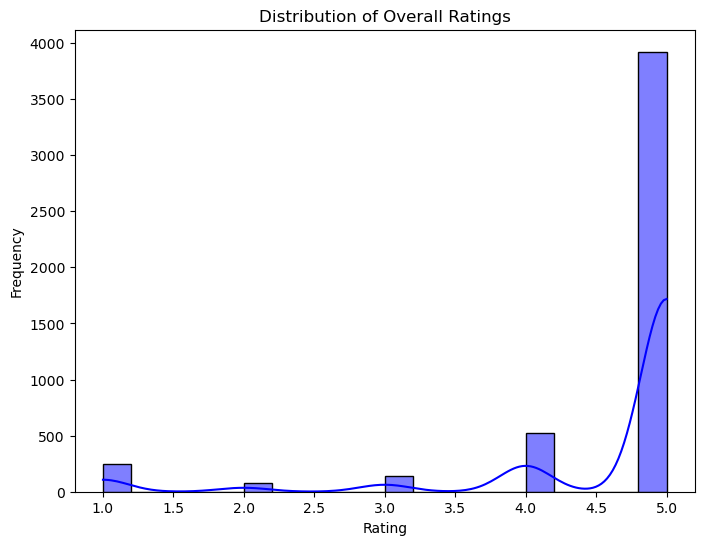

In [19]:
#Distribution of Ratings (Review overall scores)
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of 'overall' ratings
plt.figure(figsize=(8, 6))
sns.histplot(df['overall'], kde=True, color='blue', bins=20)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


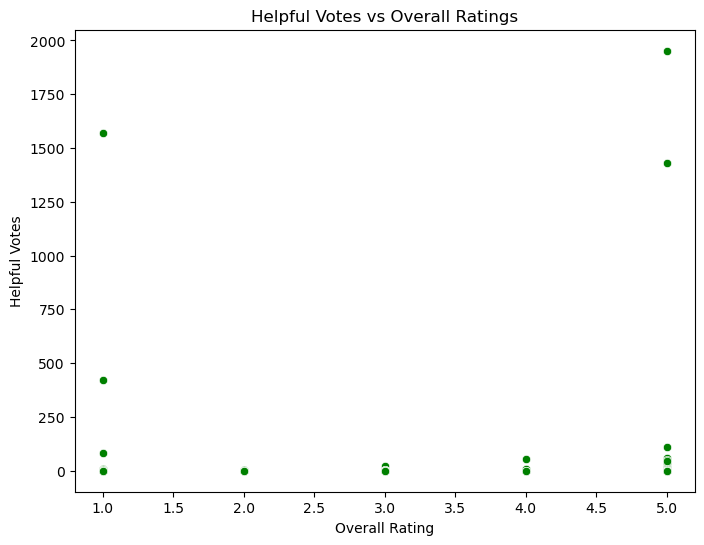

In [20]:
#Correlation Between Helpful Votes and Overall Ratings
# Scatter plot to check the relationship between 'helpful_yes' and 'overall'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='overall', y='helpful_yes', data=df, color='green')
plt.title('Helpful Votes vs Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Helpful Votes')
plt.show()


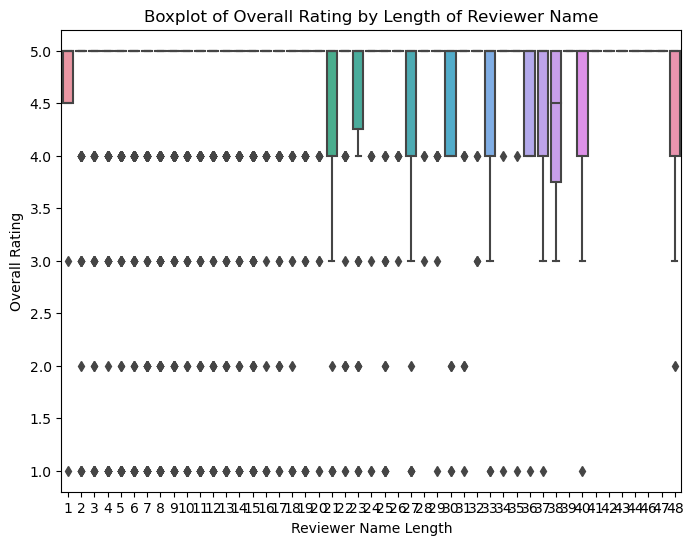

In [21]:
#Boxplot of Ratings by Reviewer Name Length
# Calculate the length of reviewer names
df['reviewerName_length'] = df['reviewerName'].apply(len)

# Boxplot of 'overall' rating by 'reviewerName_length'
plt.figure(figsize=(8, 6))
sns.boxplot(x='reviewerName_length', y='overall', data=df)
plt.title('Boxplot of Overall Rating by Length of Reviewer Name')
plt.xlabel('Reviewer Name Length')
plt.ylabel('Overall Rating')
plt.show()


C:\Users\amrut\AppData\Local\Temp\ipykernel_2796\1285679179.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


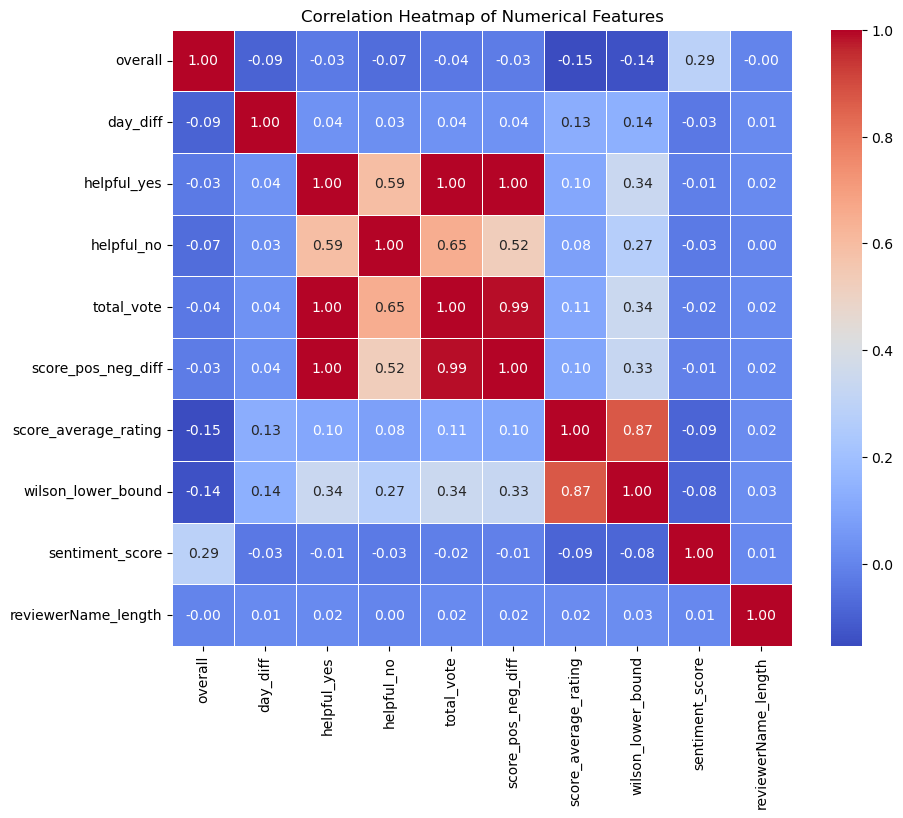

In [22]:
# Heatmap of Correlation Between Numeric Features
# Correlation heatmap for numerical columns
corr_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


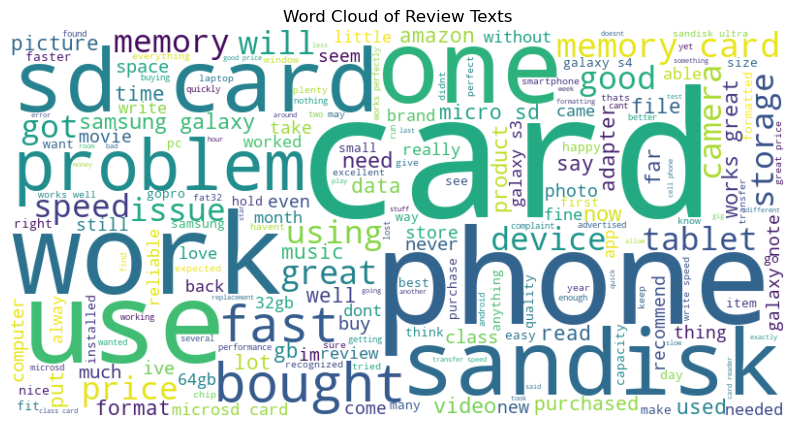

In [23]:
#Review Text Word Cloud
from wordcloud import WordCloud

# Combine all the review texts into one string
text = ' '.join(df['reviewText'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Texts')
plt.show()


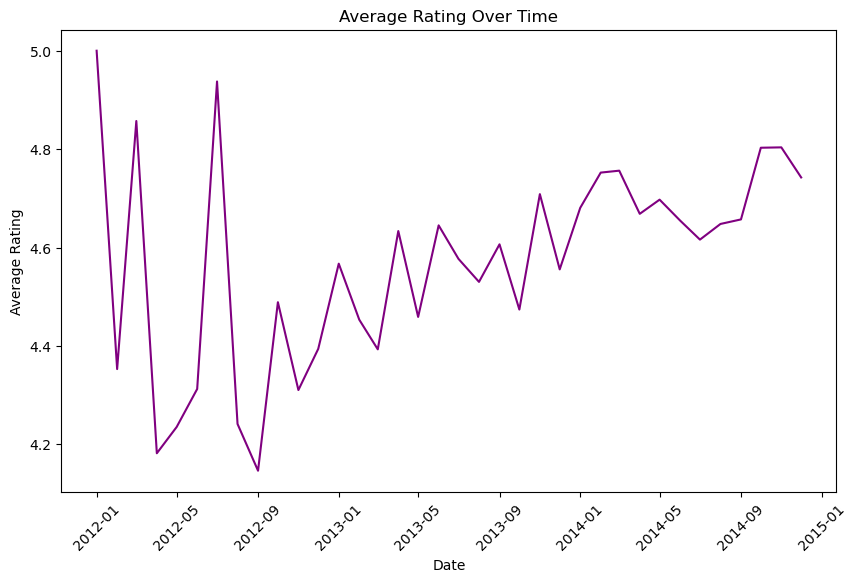

In [24]:
#Trends of Ratings Over Time
# Group by reviewTime and calculate the average overall rating
df['reviewTime'] = pd.to_datetime(df['reviewTime'])  # Ensure reviewTime is in datetime format
df_grouped = df.groupby(df['reviewTime'].dt.to_period('M')).agg({'overall': 'mean'}).reset_index()

# Plot the trend of average ratings over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_grouped['reviewTime'].dt.to_timestamp(), y=df_grouped['overall'], color='purple')
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


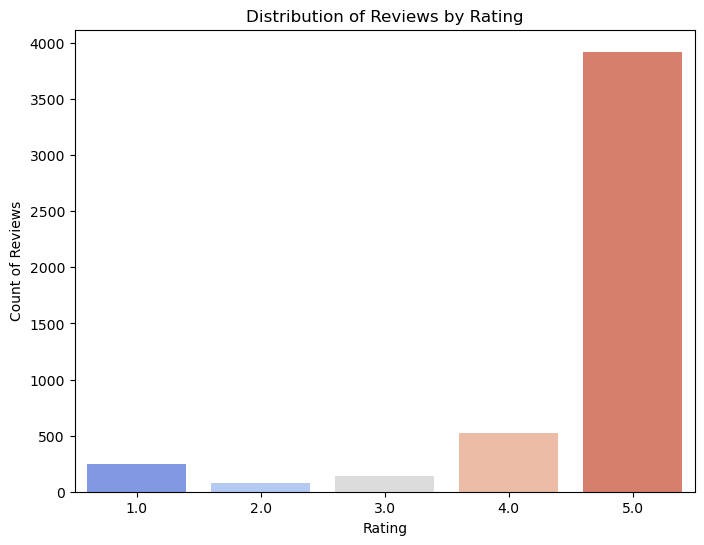

In [25]:
#Distribution of Reviews by Rating
# Count plot of reviews by 'overall' ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='overall', data=df, palette='coolwarm')
plt.title('Distribution of Reviews by Rating')
plt.xlabel('Rating')
plt.ylabel('Count of Reviews')
plt.show()


In [ ]:
#

In [ ]:
#